In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_s_curve

from Autoencoders import ConformalAutoencoder
from helper import load_optimizer_and_scheduler, save_optimizer_and_scheduler
from data import make_half_sphere

from torchvision.datasets import MNIST
from torchvision import transforms

random_state = 42
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


In [33]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, dropout_rate=0.0):
        super(Encoder, self).__init__()
        #input dim = 1, 32, 32
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 8, 3, stride=1, padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (64, 4, 4)
            nn.ELU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),  # Flatten to (256,)
            nn.ELU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),  # Flatten to (128,)
            nn.ELU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_dim)  # Output latent dimension
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(128, 256),  # Input latent dimension
            nn.ELU(True),
            nn.Linear(256, 64 * 4 * 4),  # Output size to reshape
            nn.ELU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (32, 8, 8)
            nn.ELU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (16, 16, 16)
            nn.ELU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),  # (8, 32, 32)
            nn.ELU(True),
            nn.ConvTranspose2d(8, out_channels, 3, stride=1, padding=1),  # (out_channels, 32, 32)
            nn.Sigmoid()  # For pixel values between 0 and 1
        )
    
    def forward(self, z):
        z = self.fc(z)
        z = torch.unflatten(z, 1, (64, 4, 4))  # Reshape to (64, 4, 4)
        z = self.deconv(z)
        return z

In [3]:
mnist = MNIST(root='data', train=True, download=True, transform=None)
data, labels = mnist.data, mnist.targets
data = data[labels == 3][:3000]
labels = labels[labels == 3]
data = torch.tensor(data, dtype=torch.float32).to(device)
data = transforms.Resize((32, 32))(data)  # Resize to 32x32
data = data / 255.0  # Normalize the images to [0, 1]
data = data.view(data.size(0), 1, 32, 32)  # Add channel dimension
mnist_val = MNIST(root='data', train=False, download=True, transform=None)
val_data, val_labels = mnist_val.data, mnist_val.targets
val_data = val_data[val_labels == 3][:1000]
val_labels = val_labels[val_labels == 3]
val_data = torch.tensor(val_data, dtype=torch.float32).to(device)
val_data = transforms.Resize((32, 32))(val_data)  # Resize to 32x32
val_data = val_data / 255.0  # Normalize the images to [0, 1]
val_data = val_data.view(val_data.size(0), 1, 32, 32)  # Add channel dimension

/tmp/ipykernel_404290/315428273.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_404290/315428273.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = torch.tensor(val_data, dtype=torch.float32).to(device)


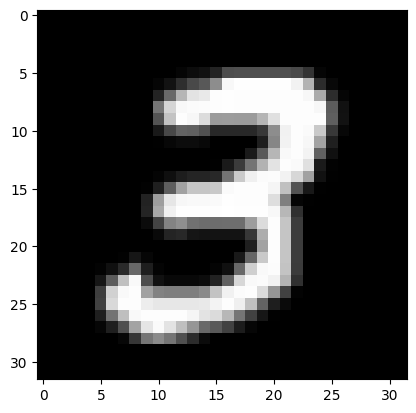

In [4]:
plt.imshow(data[0].view(32, 32).cpu().numpy(), cmap='gray')
plt.show()

In [5]:
# define model parameters
latent_dim = 24
input_dim = data.shape[1]
output_dim = data.shape[1]
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

model_path = "models/conformal_autoencoder_reg_mnist_conv_veclatent.pth"
optimizer_path = "models/conformal_autoencoder_reg_mnist_conv_veclatent_optimizer.pth"

In [6]:
from metrics import conformality_cosine_loss

In [49]:
encoder = Encoder(in_channels=1, latent_dim=latent_dim, dropout_rate=0.0).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder = ConformalAutoencoder(encoder, decoder, lambda_conf=0.0, lambda_reg=0.0).to(device)
conformal_autoencoder.conformality_loss = lambda x, y: 0.0
conformal_autoencoder.regularization_loss = lambda x, y: 0.0
optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, batch_size=batch_size,
                                                         epochs=1000, learning_rate=0.0005, log_every=100, val_every=100, 
                                                         scheduler_kwargs={"step_size": 100, "gamma": 0.7},
                                                         optimizer_kwargs={"weight_decay": 1e-7},
                                                         )

Epoch [100/1000], Loss: 0.00933126, Reconstruction Loss: 0.00933126, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [100/1000], Validation Loss: 0.01026307, Reconstruction Loss: 0.01026307, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [200/1000], Loss: 0.00478749, Reconstruction Loss: 0.00478749, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [200/1000], Validation Loss: 0.00640561, Reconstruction Loss: 0.00640561, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [300/1000], Loss: 0.00365522, Reconstruction Loss: 0.00365522, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [300/1000], Validation Loss: 0.00593155, Reconstruction Loss: 0.00593155, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [400/1000], Loss: 0.00310958, Reconstruction Loss: 0.00310958, Conformal Loss: 0.00000000, Regularization Loss: 0.00000000
Epoch [400/1000], Validation Loss: 0.00582527, Reconstruction Lo

In [8]:
encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder = ConformalAutoencoder(encoder, decoder, lambda_conf=5.67, lambda_reg=0.91).to(device)
conformal_autoencoder.conformality_loss = conformality_cosine_loss
optimizer, scheduler = conformal_autoencoder.train_model(train_dataloader, val_dataloader, batch_size=batch_size, epochs=1000, learning_rate=0.001, log_every=100, val_every=100, scheduler_kwargs={"step_size": 100, "gamma": 0.8})

Epoch [100/1000], Loss: 0.02565865, Reconstruction Loss: 0.01851928, Conformal Loss: 0.00118684, Regularization Loss: 0.00045055
Epoch [100/1000], Validation Loss: 0.02530596, Reconstruction Loss: 0.01768372, Conformal Loss: 0.00125260, Regularization Loss: 0.00057145
Epoch [200/1000], Loss: 0.02062351, Reconstruction Loss: 0.01331360, Conformal Loss: 0.00097217, Regularization Loss: 0.00197552
Epoch [200/1000], Validation Loss: 0.01958659, Reconstruction Loss: 0.01286163, Conformal Loss: 0.00090063, Regularization Loss: 0.00177846
Epoch [300/1000], Loss: 0.01678513, Reconstruction Loss: 0.01076031, Conformal Loss: 0.00083223, Regularization Loss: 0.00143525
Epoch [300/1000], Validation Loss: 0.01728522, Reconstruction Loss: 0.01070724, Conformal Loss: 0.00083437, Regularization Loss: 0.00202978


KeyboardInterrupt: 

In [10]:
from torchinfo import summary
summary(conformal_autoencoder, input_size=(200, 1, 32, 32), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"], depth=4)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ConformalAutoencoder (ConformalAutoencoder)   [200, 1, 32, 32]     [200, 1, 32, 32]     --                   True
├─Sequential (model)                          --                   --                   --                   True
│    └─Encoder (0)                            [200, 1, 32, 32]     [200, 24]            --                   True
│    │    └─Sequential (conv)                 [200, 1, 32, 32]     [200, 64, 4, 4]      --                   True
│    │    │    └─Conv2d (0)                   [200, 1, 32, 32]     [200, 8, 32, 32]     80                   True
│    │    │    └─ELU (1)                      [200, 8, 32, 32]     [200, 8, 32, 32]     --                   --
│    │    │    └─Conv2d (2)                   [200, 8, 32, 32]     [200, 16, 16, 16]    1,168                True
│    │    │    └─ELU (3)                      [200, 16, 16, 16]    [200, 16, 16, 16] 

In [14]:
conformal_autoencoder.save_checkpoint(model_path)
save_optimizer_and_scheduler(optimizer_path, optmizer, scheduler)

Checkpoint saved to models/conformal_autoencoder_reg_mnist_conv_veclatent.pth at epoch 1001
Optimizer and scheduler saved to models/conformal_autoencoder_reg_mnist_conv_veclatent_optimizer.pth


In [7]:
encoder = Encoder(in_channels=1, latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim, out_channels=1).to(device)
conformal_autoencoder = ConformalAutoencoder(encoder, decoder, lambda_conf=1.0, lambda_reg=0.8).to(device)
_=conformal_autoencoder.load_model_from_checkpoint(model_path)


Model and custom variables loaded from models/conformal_autoencoder_reg_mnist_conv_veclatent.pth


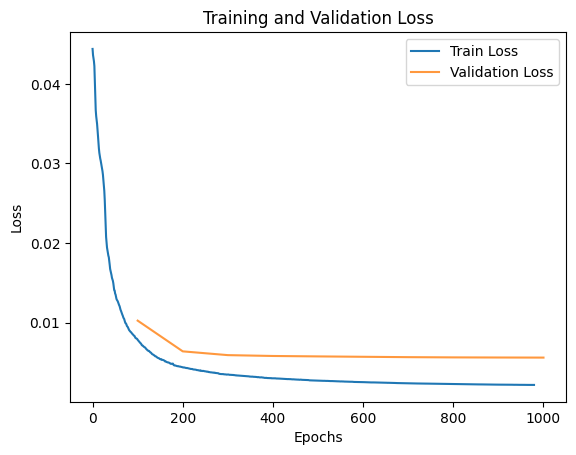

In [50]:
plt.plot(conformal_autoencoder.loss_list[20:], label='Train Loss')
plt.plot(np.linspace(100, 1000, 10), conformal_autoencoder.val_loss_list, alpha=0.8, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

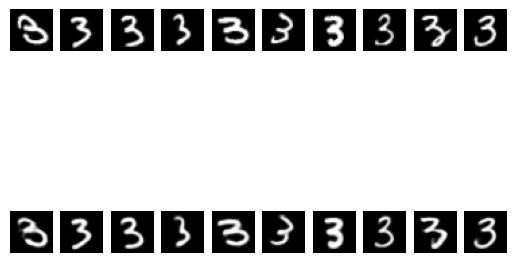

In [51]:
# Visualize the reconstructions
reconstructions = conformal_autoencoder.decode(conformal_autoencoder.encode(val_data[:10].to(device)))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(val_data[i].view(32, 32).cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructions[i].view(32, 32).cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [52]:
from metrics import evaluate_conformality
import pandas as pd

In [53]:
stats, lambda_factors = evaluate_conformality(conformal_autoencoder, val_data[:1000])

df = pd.DataFrame(stats, index=[0])

In [54]:
from metrics import regularization
regularization(conformal_autoencoder.decoder, conformal_autoencoder.encoder(val_data[:1000]).to(device)).item()

0.971377968788147

In [55]:
for stat in stats:
    print(f"{stat}: {stats[stat]}")

reconstruction_error: 0.0056147100403904915
diagonal_gini: 0.15400603413581848
lambda_mean: 0.014862658455967903
lambda_std: 0.00256560230627656
lambda_std_normed: 0.17262068390846252
lambda_factors_meanerror: 0.001170879928395152
off_diag_mean: 0.002671554684638977
off_diag_norm: 0.08261751383543015
off_diag_mean_normed: 0.17833435535430908
off_diag_norm_normed: 5.510275363922119
jTj_minus_lambdaI_mean: 0.0028059775941073895
jTj_minus_lambdaI_norm: 0.08505159616470337
jTj_minus_lambdaI_mean_normed: 0.18727754056453705
jTj_minus_lambdaI_norm_normed: 5.671645641326904
determinant_vs_estimate_mean: 0.0
determinant_vs_estimate_std: 0.0
determinant_vs_estimate_mse: 2.1945454990098095e-40
determinant_vs_estimate_estimate_mean: 0.0
log_determinant_vs_estimate_mean: -16.273576736450195
log_determinant_vs_estimate_std: 1.589248776435852
log_determinant_vs_estimate_estimate_mean: -50.77055740356445
latent_std: 17.715087890625
latent_std_max: 26.64607048034668
latent_std_min: 10.553671836853027


In [37]:
for stat in stats:
    print(f"{stat}: {stats[stat]}")

reconstruction_error: 0.0032058435960188904
diagonal_gini: 0.04461904225185798
lambda_mean: 0.9723520444349906
lambda_std: 0.09098760867646404
lambda_std_normed: 0.09357475946824861
off_diag_mean: 0.04123085133192407
off_diag_norm: 1.271903280857242
off_diag_mean_normed: 0.04320701736865272
off_diag_norm_normed: 1.3328806568885134
jTj_minus_lambdaI_mean: 0.043677532835069484
jTj_minus_lambdaI_norm: 1.3222781153665322
jTj_minus_lambdaI_mean_normed: 0.04577182067432346
jTj_minus_lambdaI_norm_normed: 1.3856120181084817
determinant_vs_estimate_mean: 0.5716919073221847
determinant_vs_estimate_std: 0.20604455662473392
log_determinant_vs_estimate_mean: -0.6479669145040914
log_determinant_vs_estimate_std: 0.4666303137257457
latent_std: 1.7347316792262897
latent_std_max: 2.4325327299167254
latent_std_min: 1.3192667620566898
latent_norm: 144.8563829465832


In [13]:
lambda_factors.dtype

torch.float32

(array([  1.,   0.,   0.,   0.,   1.,   3.,   9.,   8.,  11.,  14.,  16.,
         22.,  34.,  42.,  58.,  81.,  81.,  96., 101.,  98.,  69.,  74.,
         57.,  40.,  44.,  20.,  10.,   6.,   1.,   3.]),
 array([0.82133734, 0.83132911, 0.84132087, 0.8513127 , 0.86130446,
        0.87129623, 0.88128799, 0.89127976, 0.90127158, 0.91126335,
        0.92125511, 0.93124688, 0.94123864, 0.95123047, 0.96122223,
        0.971214  , 0.98120576, 0.99119759, 1.00118935, 1.01118112,
        1.02117288, 1.03116465, 1.04115641, 1.05114818, 1.06114006,
        1.07113171, 1.08112359, 1.09111536, 1.10110712, 1.11109889,
        1.12109065]),
 <BarContainer object of 30 artists>)

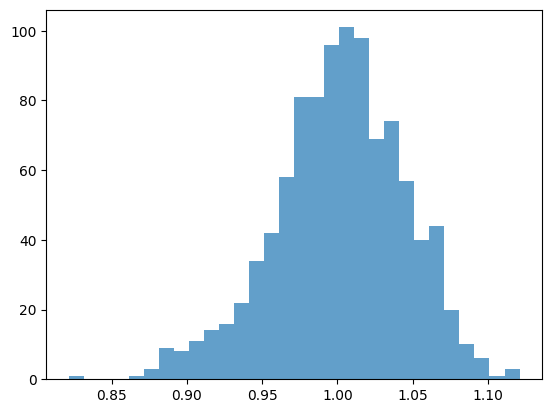

In [14]:
plt.hist(lambda_factors.detach().cpu().numpy(), bins=30, alpha=0.7)

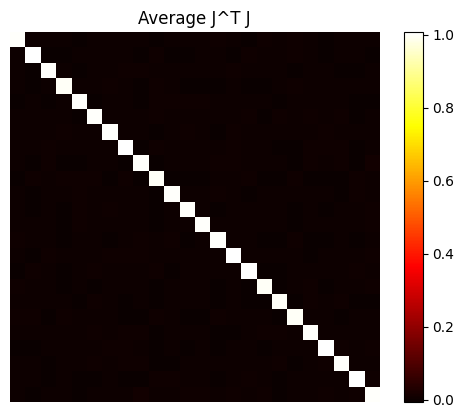

In [16]:

conformal_autoencoder.eval()
with torch.no_grad():
    encoded_data = conformal_autoencoder.encode(val_data[:1000])
    reconstruction = conformal_autoencoder.decode(encoded_data)

JtJs = torch.zeros((latent_dim, latent_dim)).to(device)
for i, z in enumerate(encoded_data):
    z = z.unsqueeze(0)  # Add batch dimension

    J = torch.autograd.functional.jacobian(conformal_autoencoder.decoder, z)[0,0,:,:,0,:]
    J = J.reshape(-1, 24)  # Reshape to (latent_dim, flattened_output_dim)
    JtJ = J.transpose(0, 1) @ J
    JtJs += JtJ

JtJs /= encoded_data.shape[0]  # Average over all points

plt.imshow(JtJs.cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Average J^T J')
plt.axis('off')
plt.show()

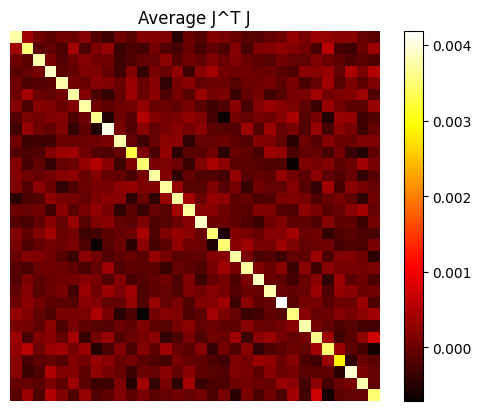

In [15]:

conformal_autoencoder.eval()
with torch.no_grad():
    encoded_data = conformal_autoencoder.encode(val_data[:1000])
    reconstruction = conformal_autoencoder.decode(encoded_data)

JtJs = torch.zeros((latent_dim, latent_dim)).to(device)
for i, z in enumerate(encoded_data):
    z = z.unsqueeze(0)  # Add batch dimension

    J = torch.autograd.functional.jacobian(conformal_autoencoder.decoder, z)[0,0,:,:,0,:]
    J = J.reshape(-1, 32)  # Reshape to (latent_dim, flattened_output_dim)
    JtJ = J.transpose(0, 1) @ J
    JtJs += JtJ

JtJs /= encoded_data.shape[0]  # Average over all points

plt.imshow(JtJs.cpu().numpy(), cmap='hot')
plt.colorbar()
plt.title('Average J^T J')
plt.axis('off')
plt.show()

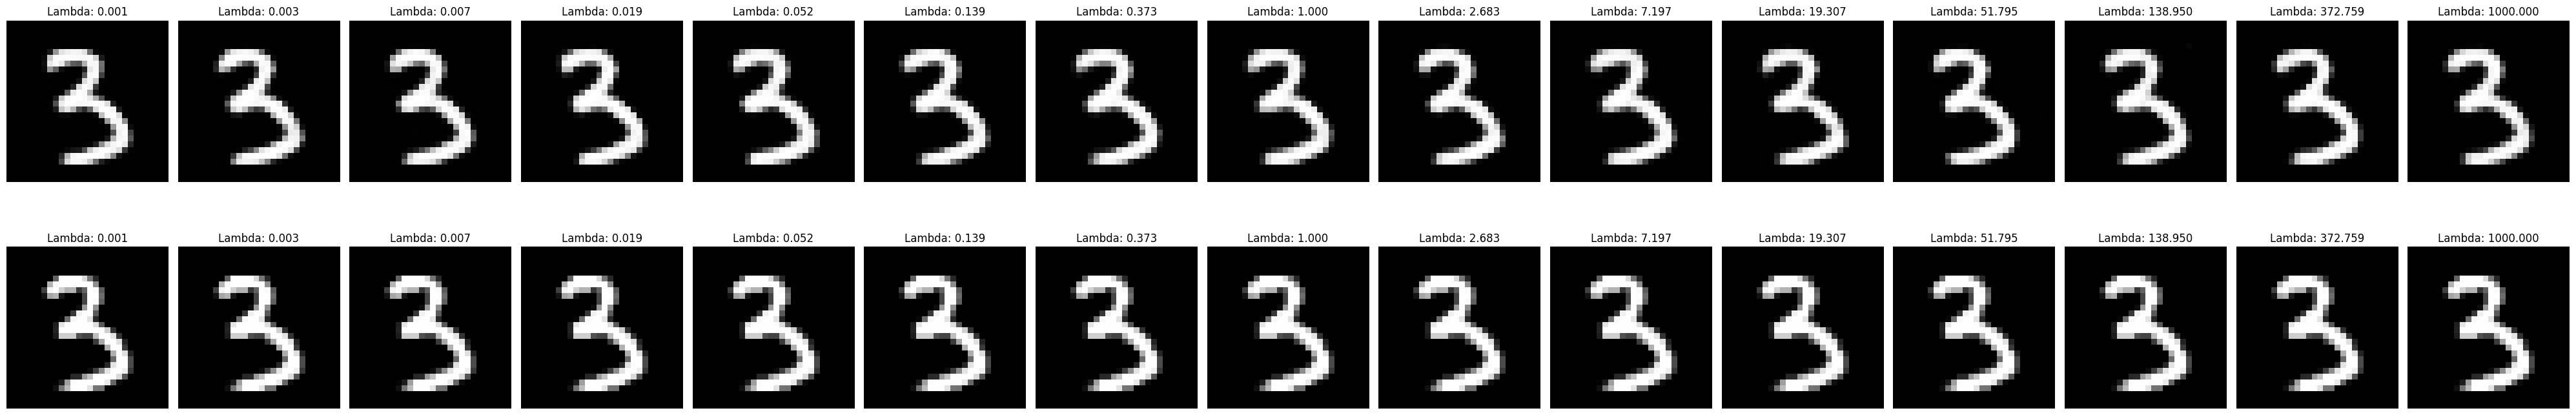

In [ ]:
# plot samples and latent space at different lambdas
fig, axs = plt.subplots(2, 10, figsize=(40, 8))
for i in range(10):

    # model.eval()
    # with torch.no_grad():
    encoded_data = model.encode(val_data[:10])
    reconstruction = model.decode(encoded_data)

    axs[0, i].imshow(reconstruction[2].view(28, 28).cpu().detach().numpy(), cmap='gray')
    axs[0, i].set_title(f'Lambda: {lambda_iso:.3f}')
    axs[0, i].axis('off')

    axs[1, i].imshow(val_data[2].view(28, 28).cpu().detach().numpy(), cmap='gray')
    axs[1, i].set_title(f'Lambda: {lambda_iso:.3f}')
    axs[1, i].axis('off')
plt.tight_layout()

In [48]:
model_path = f"models/conformal_autoencoder_mnist/lambda_{lambda_isos[-1]:.3f}_model_1.pth"
model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_isos[-1]).to(device)
model.load_state_dict(torch.load(model_path))

model.eval()
with torch.no_grad():
    encoded_data = model.encode(val_data[:2])
    reconstruction = model.decode(encoded_data)


    for i, z in enumerate(encoded_data):
        z = z.unsqueeze(0)  # Add batch dimension
        y = model.decoder(z)  # Decode to get reconstruction
        y = y.squeeze(0)  # Remove batch dimension

        # Compute the Jacobian J of the decoder at point z
        J = torch.autograd.functional.jacobian(model.decoder, z)[0,:,0,:]
        JtJ = J.transpose(0, 1) @ J
        print(JtJ.size())
        print(encoded_data.size())

    #     eye = torch.eye(JtJ.size(0), device=device)
    #     off_diag_mask = 1.0 - eye
    #     off_diag_elements = JtJ[off_diag_mask.bool()]
    #     loss_matrix = off_diag_elements ** 2

    #     losses.append(loss_matrix.mean().item())
    
    # return np.mean(losses).item()

torch.Size([28, 28, 1, 64, 1, 1])
torch.Size([2, 64, 1, 1])
torch.Size([28, 28, 1, 64, 1, 1])
torch.Size([2, 64, 1, 1])


In [49]:
print(JtJ[:,:,0,0,0,0])

tensor([[ 3.0352e-18,  5.2367e-17,  2.9216e-18,  1.0972e-19,  5.9667e-21,
          9.4161e-21,  1.8404e-21,  2.0862e-22,  4.2756e-22,  2.7949e-20,
          9.5245e-20,  7.9838e-20,  2.1337e-22,  1.2245e-24,  4.7852e-26,
          3.2307e-27, -4.6334e-24, -4.1562e-23, -4.6581e-21, -5.7762e-21,
          9.4572e-24,  4.5367e-25,  2.4468e-23,  3.7554e-24,  8.7466e-24,
          2.5008e-23,  3.5209e-21,  2.7895e-17],
        [ 5.2367e-17,  9.0350e-16,  5.0408e-17,  1.8931e-18,  1.0295e-19,
          1.6246e-19,  3.1753e-20,  3.5994e-21,  7.3769e-21,  4.8221e-19,
          1.6433e-18,  1.3775e-18,  3.6813e-21,  2.1127e-23,  8.2561e-25,
          5.5740e-26, -7.9941e-23, -7.1709e-22, -8.0368e-20, -9.9658e-20,
          1.6317e-22,  7.8273e-24,  4.2215e-22,  6.4794e-23,  1.5091e-22,
          4.3147e-22,  6.0748e-20,  4.8128e-16],
        [ 2.9216e-18,  5.0408e-17,  2.8124e-18,  1.0562e-19,  5.7435e-21,
          9.0639e-21,  1.7716e-21,  2.0082e-22,  4.1157e-22,  2.6903e-20,
          9.16

In [35]:
def diagonality_loss(func, z):
    device = z.device
    losses = []
    for i, z in enumerate(encoded_data):
        z = z.unsqueeze(0)  # Add batch dimension
        y = func(z)  # Decode to get reconstruction
        y = y.squeeze(0)  # Remove batch dimension

        # Compute the Jacobian J of the decoder at point z
        J = torch.autograd.functional.jacobian(func, z)[0,:,0,:]
        JtJ = J.transpose(0, 1) @ J

        eye = torch.eye(JtJ.size(0), device=device)
        off_diag_mask = 1.0 - eye
        off_diag_elements = JtJ[off_diag_mask.bool()]
        loss_matrix = off_diag_elements ** 2

        losses.append(loss_matrix.mean().item())
    
    return np.mean(losses).item()

In [37]:
# measure isometry, scaled isometry, conformity, diagonality, (angle preservation, kl)
from metrics import isometry_loss, scaled_isometry_loss, conformality_loss

for i, lambda_iso in enumerate(lambda_isos):
    print(f"Evaluating model with lambda_iso={lambda_iso:.3f}")
    model_path = f"models/conformal_autoencoder_mnist/lambda_{lambda_iso:.3f}_model_1.pth"
    model = ConformalAutoencoder(Encoder(input_dim, latent_dim), Decoder(latent_dim, output_dim), lambda_conf=lambda_iso).to(device)
    model.load_state_dict(torch.load(model_path))

    model.eval()
    with torch.no_grad():
        encoded_data = model.encode(val_data[:10])
        reconstruction = model.decode(encoded_data)

    isometry = isometry_loss(model.decoder, encoded_data, create_graph=False, augment=False)
    scaled_isometry = scaled_isometry_loss(model.decoder, encoded_data, create_graph=False, augment=False)
    # conformality = conformality_loss(model.decoder, encoded_data)
    diagonality = diagonality_loss(model.decoder, encoded_data)
    print(f"Isometry Loss: {isometry.item()}")
    print(f"Scaled Isometry Loss: {scaled_isometry.item()}")
    # print(f"Conformality Loss: {conformality.item()}")
    print(f"Diagonality Loss: {diagonality}")
    print("-" * 50)

Evaluating model with lambda_iso=0.001
Isometry Loss: 0.9985315203666687
Scaled Isometry Loss: 0.04870064929127693
Diagonality Loss: 1.305166555744099e-26
--------------------------------------------------
Evaluating model with lambda_iso=0.003
Isometry Loss: 0.9976233243942261
Scaled Isometry Loss: 0.045477449893951416
Diagonality Loss: 6.155378930229709e-29
--------------------------------------------------
Evaluating model with lambda_iso=0.007
Isometry Loss: 0.9979907870292664
Scaled Isometry Loss: 0.049913208931684494
Diagonality Loss: 1.2167631827168267e-27
--------------------------------------------------
Evaluating model with lambda_iso=0.019
Isometry Loss: 0.9984010457992554
Scaled Isometry Loss: 0.053543947637081146
Diagonality Loss: 5.195471863699401e-24
--------------------------------------------------
Evaluating model with lambda_iso=0.052
Isometry Loss: 0.9984318614006042
Scaled Isometry Loss: 0.047817811369895935
Diagonality Loss: 2.914123903857391e-24
----------------